<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week11/kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means clustering
- basic examples and visualizations

## Datasets

### Face

In [2]:
import numpy as np

def generate_face_points(num_points=500):
    # Eyes
    eye1_center = np.array([-1.5, 0.6])
    eye2_center = np.array([1.5, 0.6])
    eye_radius = 0.15

    eye1 = np.random.multivariate_normal(eye1_center, eye_radius*np.eye(2), size=num_points//4)
    eye2 = np.random.multivariate_normal(eye2_center, eye_radius*np.eye(2), size=num_points//4)

    # Nose
    nose_center = np.array([0, -0.8])
    nose = np.random.multivariate_normal(nose_center, (eye_radius/4)*np.eye(2), size=num_points//8)

    # Mouth
    mouth_length = 3.0
    mouth_center = np.array([0, -1])

    mouth_theta = np.linspace(-np.pi/2, np.pi/2, num_points//2)
    mouth_x = mouth_theta
    mouth_y = mouth_length * (mouth_theta**2 * 0.25 - 1) + np.random.normal(0, 0.21, size=mouth_theta.shape)
    mouth = np.vstack((mouth_x, mouth_y)).T

    # Combine all
    points = np.vstack((eye1, eye2, mouth, nose))

    return points


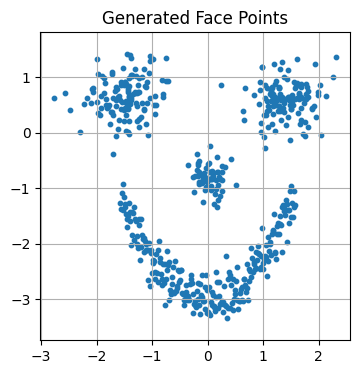

In [3]:
points = generate_face_points(500)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.scatter(points[:,0], points[:,1], s=10)
plt.title('Generated Face Points')
plt.axis('equal')
plt.grid(True)
plt.show()

### Countries:

In [4]:
import urllib.request
import pandas as pd

url = 'https://raw.githubusercontent.com/reitezuz/18NES1-2025-/main/week11/countries.csv'
filename = 'countries.csv'

# Load file
urllib.request.urlretrieve(url, filename)


df = pd.read_csv('countries.csv', sep=';')
print(df.head())
print("\nShape:", df.shape)

           Country  Population  Area (sq. mi.)
0     Afghanistan     31056997          647500
1         Albania      3581655           28748
2         Algeria     32930091         2381740
3  American Samoa        57794             199
4         Andorra        71201             468

Shape: (227, 3)


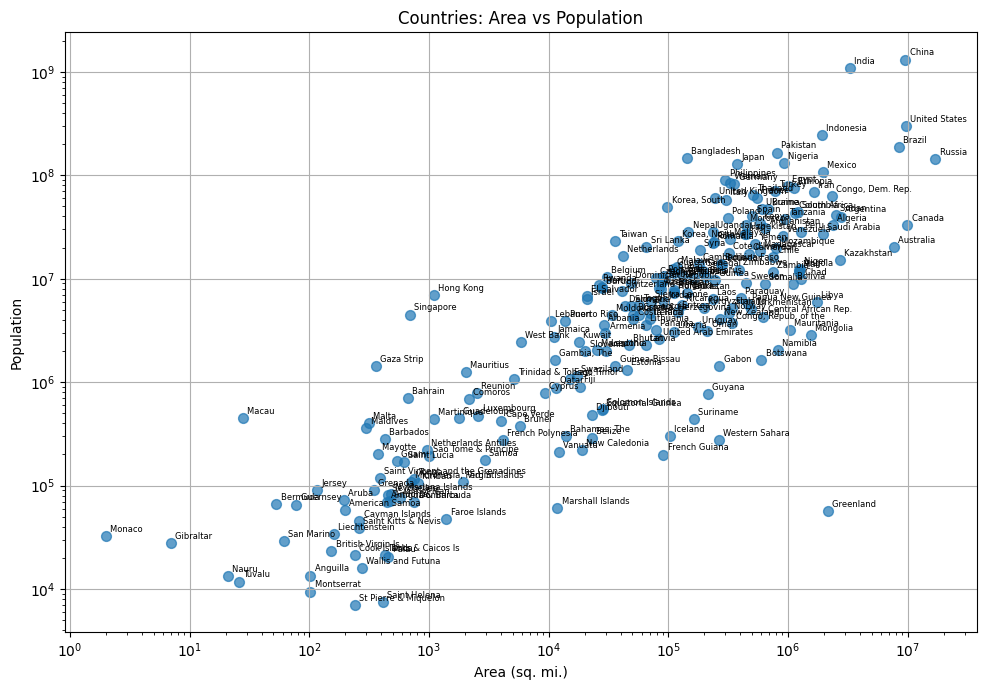

In [5]:
import matplotlib.pyplot as plt

# Scatter plot Area vs Population
plt.figure(figsize=(10, 7))
plt.scatter(df['Area (sq. mi.)'], df['Population'], s=50, alpha=0.7)

# Country names
for i in range(len(df)):
    plt.annotate(df['Country'][i],
                 (df['Area (sq. mi.)'][i], df['Population'][i]),
                 textcoords="offset points", xytext=(3,3), ha='left', fontsize=6)

plt.xscale('log')  # logarithmic scale (area)
plt.yscale('log')  # logarithmic scale (population)
plt.xlabel('Area (sq. mi.)')
plt.ylabel('Population')
plt.title('Countries: Area vs Population')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

def prepare_countries_data(local_filename='countries.csv'):
    """
    Prepare data for clustering.

    Parameters:
    local_filename (str): local filename

    Returns:
    X_scaled (np.ndarray): normalized features
    names (np.ndarray): country names
    """

    # Parse CSV
    df = pd.read_csv(local_filename, sep=';')

    # Features for clustering
    X = df[['Area (sq. mi.)', 'Population']].values

    # Normalize features ... logarithm and minmax:
    X = np.log(X)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Names (for visualization or labeling)
    names = df['Country'].values

    return X_scaled, names

X_countries, country_names = prepare_countries_data()

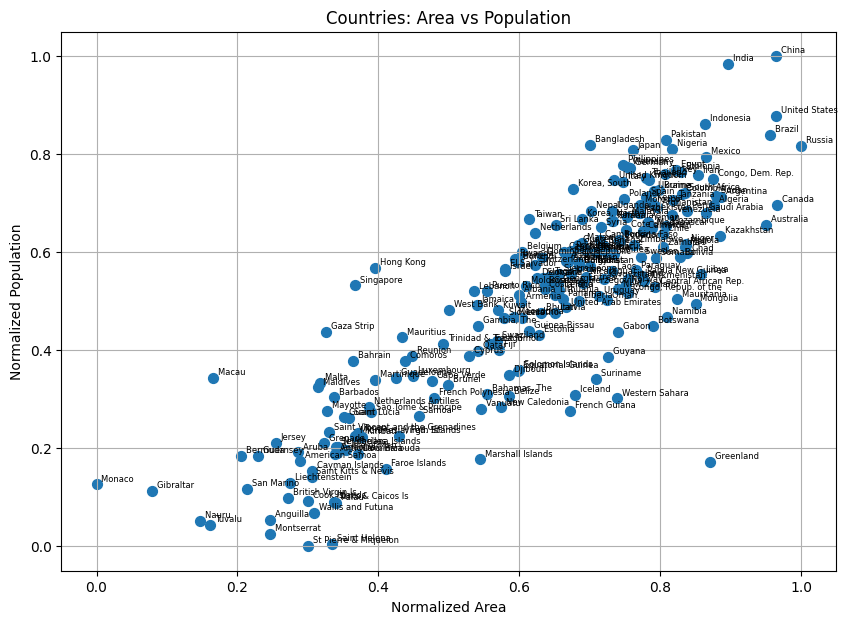

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,7))
plt.scatter(X_countries[:, 0], X_countries[:, 1], s=50)

# Country names
for i, name in enumerate(country_names):
    plt.text(X_countries[i, 0]+0.007, X_countries[i, 1]+0.007, name,
             ha='left', fontsize=6)

plt.xlabel('Normalized Area')
plt.ylabel('Normalized Population')
plt.title('Countries: Area vs Population')
plt.grid(True)
plt.show()

# KMeans step by step example:

## Chose the dataset
- blobs1, blobs2 - simple 2D data
- face, moons, circle - hard exampes
- iris, countries - real-world data

In [8]:
# Choose dataset
dataset_choice = 'blobs1'  # options: 'blobs1', 'blobs2', 'face', 'moons', 'circles', 'iris', 'countries'

import numpy as np
from sklearn.datasets import make_blobs, make_circles, make_moons, load_iris
from sklearn.preprocessing import MinMaxScaler, StandardScaler

if dataset_choice == 'blobs1':
    data, _ = make_blobs(n_samples=300, centers=[[1,1], [-1,-1], [2,-2]], cluster_std=[0.75, 0.5, 0.5], random_state=42)
    #data, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=42)
elif dataset_choice == 'blobs2':
    data, _ = make_blobs(n_samples=400, centers=[[1,1], [1,-0.5], [-1,-1], [2,-2]], cluster_std=[0.25, 0.75, 0.5, 0.5], random_state=42)

elif dataset_choice == 'face':
    data = generate_face_points()
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
elif dataset_choice == 'moons':
    data = make_moons(n_samples=300, noise=0.1, random_state=42)[0]
elif dataset_choice == 'circles':
    data = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)[0]


elif dataset_choice == 'iris':
    iris = load_iris()
    data = iris.data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
elif dataset_choice == 'countries':
    data, _ = prepare_countries_data()
else:
    raise ValueError("Unknown dataset choice.")

print(f'Data shape: {data.shape}')

Data shape: (300, 2)


## Initialize the centroids

In [9]:
# Parameters
k = 8  # number of clusters

# Choose initialization method
init_method = 'random_range'  # options: 'mean', 'random_range', 'random_data', 'kmeans++'

def initialize_centroids(data, k, method='random_data', seed = None):
    if seed is not None:
        np.random.seed(seed)
    if init_method == 'mean':
        # All centroids initialized at the mean of the dataset
        centroids = np.tile(np.mean(data, axis=0), (k, 1))
    elif init_method == 'random_range':
        # Centroids initialized randomly within the range of the data
        min_vals = np.min(data, axis=0)
        max_vals = np.max(data, axis=0)
        centroids = np.random.rand(k, data.shape[1]) * (max_vals - min_vals) + min_vals
    elif init_method == 'random_data':
        # Centroids initialized as random samples from the data
        indices = np.random.choice(len(data), size=k, replace=False)
        centroids = data[indices]
    elif init_method == 'kmeans++':
        # Basic implementation of k-means++ initialization
        centroids = []
        centroids.append(data[np.random.choice(len(data))])
        for _ in range(1, k):
            dist_sq = np.min([np.sum((data - c)**2, axis=1) for c in centroids], axis=0)
            probs = dist_sq / np.sum(dist_sq)
            next_centroid = data[np.random.choice(len(data), p=probs)]
            centroids.append(next_centroid)
        centroids = np.array(centroids)
    else:
        raise ValueError("Unknown initialization method.")
    return centroids

initial_centroids = initialize_centroids(data, k, init_method, seed = 42)
print(f'Centroids shape: {initial_centroids.shape}')


Centroids shape: (8, 2)


### Visualize initial data and centroids

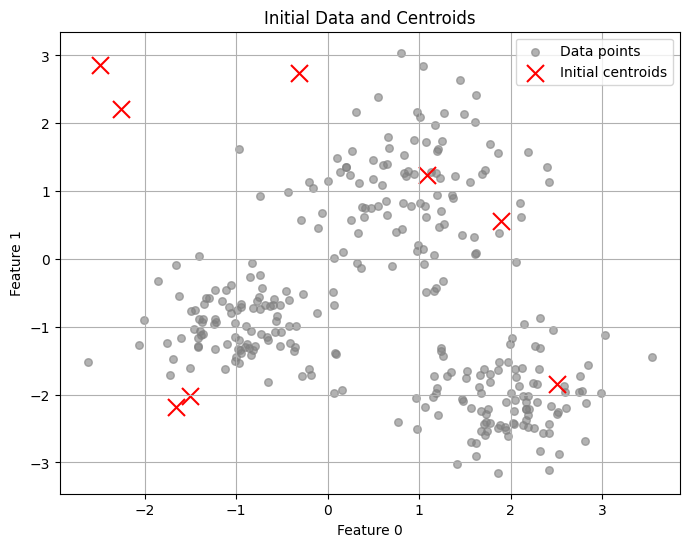

In [10]:
# Choose dimensions to plot (in case of higher dimensional data)
dims = (0, 1)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(data[:, dims[0]], data[:, dims[1]], c='gray', s=30, alpha=0.6, label='Data points')
plt.scatter(initial_centroids[:, dims[0]], initial_centroids[:, dims[1]], c='red', marker='x', s=150, label='Initial centroids')
plt.xlabel(f'Feature {dims[0]}')
plt.ylabel(f'Feature {dims[1]}')
plt.title('Initial Data and Centroids')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def plot_final_result(data, assignments, centroids, dims):
  #
  # Plot final result
  plt.figure(figsize=(8,6))
  for cluster_idx in range(k):
      cluster_data = data[assignments == cluster_idx]
      plt.scatter(cluster_data[:, dims[0]], cluster_data[:, dims[1]], s=30, label=f'Cluster {cluster_idx}')
  plt.scatter(final_centroids[:, dims[0]], final_centroids[:, dims[1]], c='black', marker='*', s=200, label='Final centroids')
  plt.xlabel(f'Feature {dims[0]}')
  plt.ylabel(f'Feature {dims[1]}')
  plt.title('Final Clustering Result')
  plt.legend()
  plt.grid(True)
  plt.show()


## KMeans:  Own Implementation

#### simple_kmeans_numpy

In [12]:
import numpy as np

def simple_kmeans_numpy(data, k=3, initial_centroids=None, max_iter=300, tol=1e-4, distance='euclidean'):
    """
    Simple KMeans clustering using only NumPy, with flexible distance metrics,
    and recording centroid history for visualization.

    Returns:
    - assignments (np.ndarray): cluster assignment for each sample
    - centroids (np.ndarray): final centroid positions
    - centroid_history (list of np.ndarray): centroids at each iteration
    """
    #np.random.seed(42)

    n_samples, n_features = data.shape

    # Step 1: Initialize centroids
    if initial_centroids is None:
        centroids = initialize_centroids(data, k)
    elif type(initial_centroids) == np.ndarray:
        centroids = initial_centroids
    elif isinstance(initial_centroids, str):
        centroids = initialize_centroids(data, k,  initial_centroids)

    centroid_history = [centroids.copy()]  # <-- store initial centroids
    assignment_history = []

    for iteration in range(max_iter):
        # Step 2: Compute distances to centroids
        if distance == 'euclidean':
            distances = np.linalg.norm(data[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
        elif distance == 'manhattan':
            distances = np.sum(np.abs(data[:, np.newaxis, :] - centroids[np.newaxis, :, :]), axis=2)
        elif distance == 'cosine':
            data_norm = np.linalg.norm(data, axis=1, keepdims=True)
            centroids_norm = np.linalg.norm(centroids, axis=1, keepdims=True)
            similarity = np.dot(data, centroids.T) / (data_norm * centroids_norm.T + 1e-10)
            distances = 1 - similarity
        else:
            raise ValueError("Unsupported distance metric.")

        # Step 3: Assign points
        assignments = np.argmin(distances, axis=1)
        assignment_history.append(assignments.copy())

        # Step 4: Update centroids
        new_centroids = np.zeros_like(centroids)
        for cluster_idx in range(k):
            if np.any(assignments == cluster_idx):
                new_centroids[cluster_idx] = data[assignments == cluster_idx].mean(axis=0)
            else: # reinitialize cluster with no points
                # new_centroids[cluster_idx] = data[np.random.choice(n_samples)] # improvement
                new_centroids[cluster_idx] = centroids[cluster_idx]

        # Step 5: Convergence check
        centroid_shift = np.linalg.norm(new_centroids - centroids)
        if centroid_shift < tol:
            print(f"Converged after {iteration} iterations.")
            break

        centroids = new_centroids
        centroid_history.append(centroids.copy())  # <-- record new centroids
    assignment_history.append(assignments.copy())
    return assignments, centroids, centroid_history, assignment_history


#### plot_final_result_with_history

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_final_result_with_history(data, assignment_history, centroid_history,  dims=(0, 1), steps=0):
    """
    Plot final clustering and show centroid movement paths up to a given step,
    without hiding the final centroid markers.
    """
    k = centroid_history[0].shape[0]

    if steps == 0:
        steps = len(centroid_history)

    colors = plt.cm.tab10(np.linspace(0, 1, k))

    plt.figure(figsize=(10, 8))
    assignments = assignment_history[steps-1]
    # Plot data points
    for cluster_idx in range(k):
        cluster_color = colors[cluster_idx]
        plt.scatter(data[assignments == cluster_idx, dims[0]],
                    data[assignments == cluster_idx, dims[1]],
                    color=cluster_color, alpha=0.6, label=f'Cluster {cluster_idx}')

    # Plot centroid paths as lines (without points)
    for cluster_idx in range(k):
        cluster_color = colors[cluster_idx]
        path = np.array([c[cluster_idx] for c in centroid_history[:steps]])
        plt.plot(path[:, dims[0]], path[:, dims[1]],
                 linestyle='-', color=cluster_color, linewidth=2, label=f'Centroid {cluster_idx} path')

    # Plot final centroid positions as black stars
    final_centroids = centroid_history[steps-1]
    for cluster_idx in range(k):
        plt.scatter(final_centroids[cluster_idx, dims[0]],
                    final_centroids[cluster_idx, dims[1]],
                    color='black', marker='*', s=200, zorder=5)

    plt.xlabel(f'Feature {dims[0]}')
    plt.ylabel(f'Feature {dims[1]}')
    plt.title(f'Centroid Movement (Step {steps-1})')
    plt.legend()
    plt.grid(True)
    plt.show()


### Run the algorithm and visualize the training process:

Converged after 11 iterations.
Centroids:
 [[ 1.42498349  1.86193713]
 [ 1.30991404  0.21237819]
 [-1.45232539 -0.91095705]
 [ 0.0100737   0.65096876]
 [ 0.68832395  1.2266172 ]
 [-2.49383166  2.85383614]
 [ 1.97748131 -2.06313634]
 [-0.61732333 -1.05140353]]


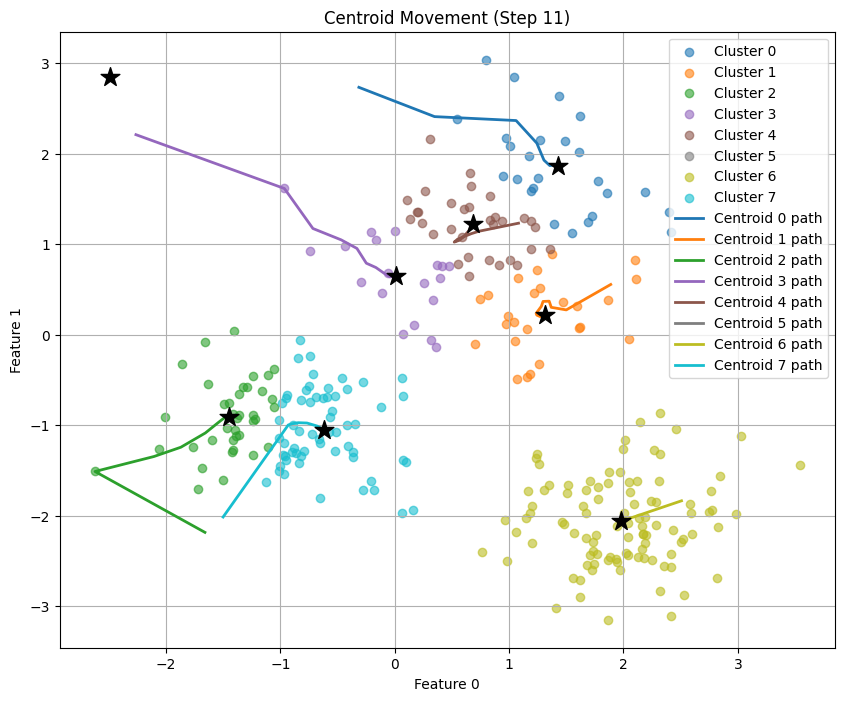

In [16]:
# Run KMeans
assignments, final_centroids, centroid_history, assignment_history = simple_kmeans_numpy(data, k=k, initial_centroids=initial_centroids, distance='euclidean')


# Uncomment the following line to reinitialize the centroids
#assignments, final_centroids, centroid_history = simple_kmeans_numpy(data, k=3, initial_centroids='mean', distance='euclidean')

# Plot final result
print("Centroids:\n", final_centroids)

# Plot the final result with movement paths
plot_final_result_with_history(data, assignment_history, centroid_history, dims=(0, 1))

### Animation of the training process:

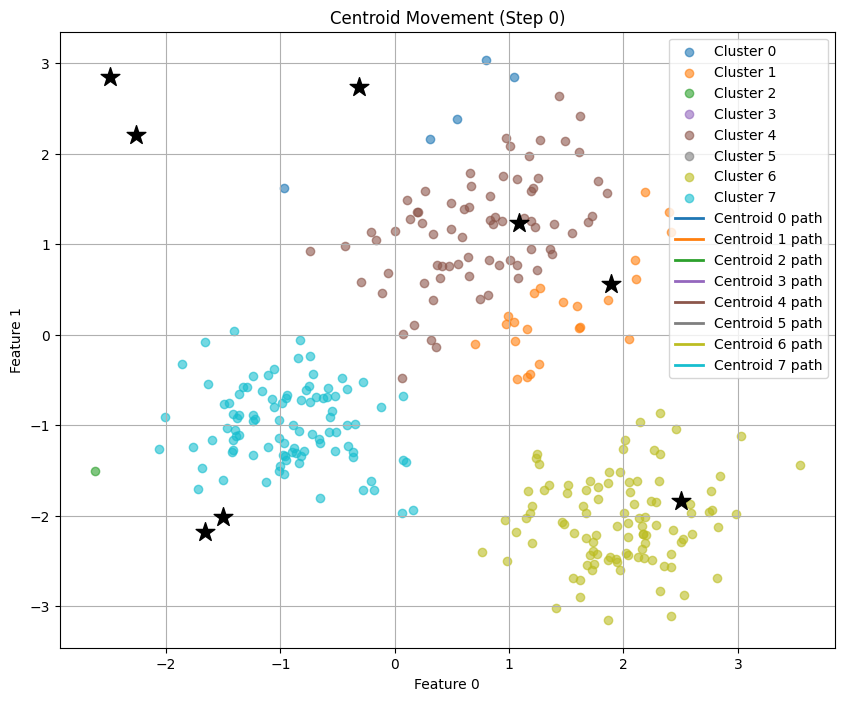

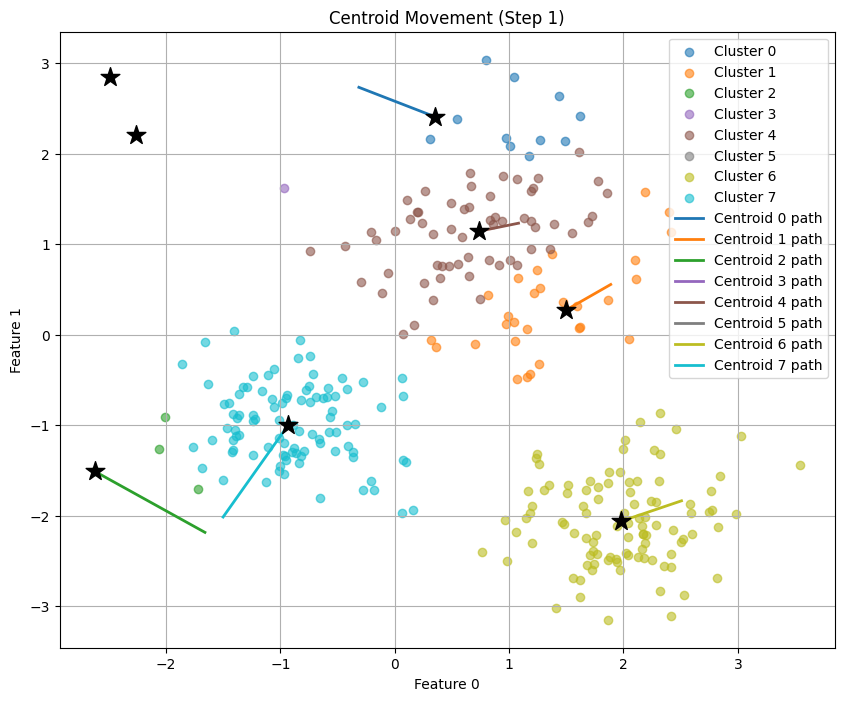

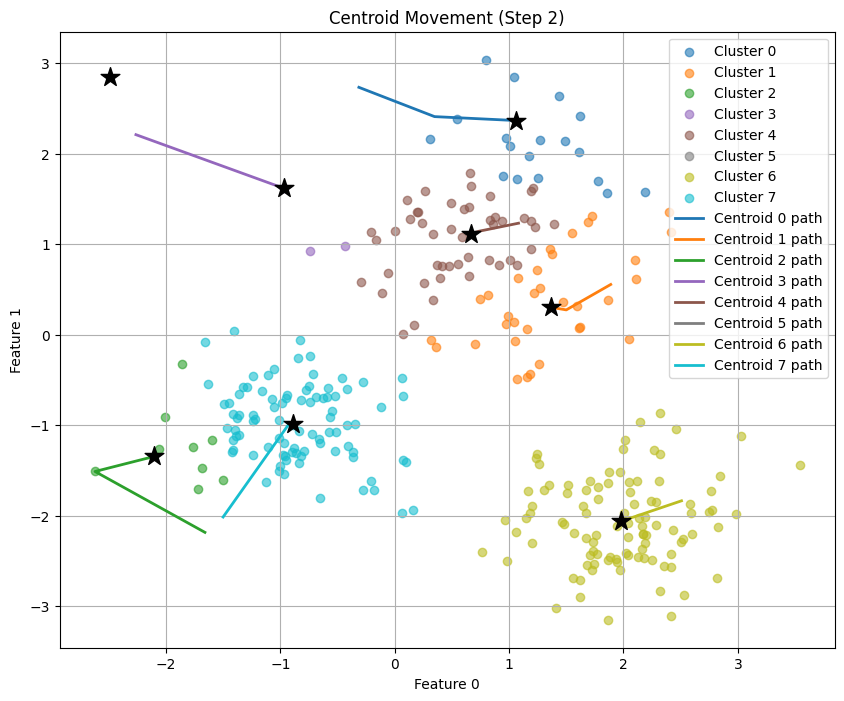

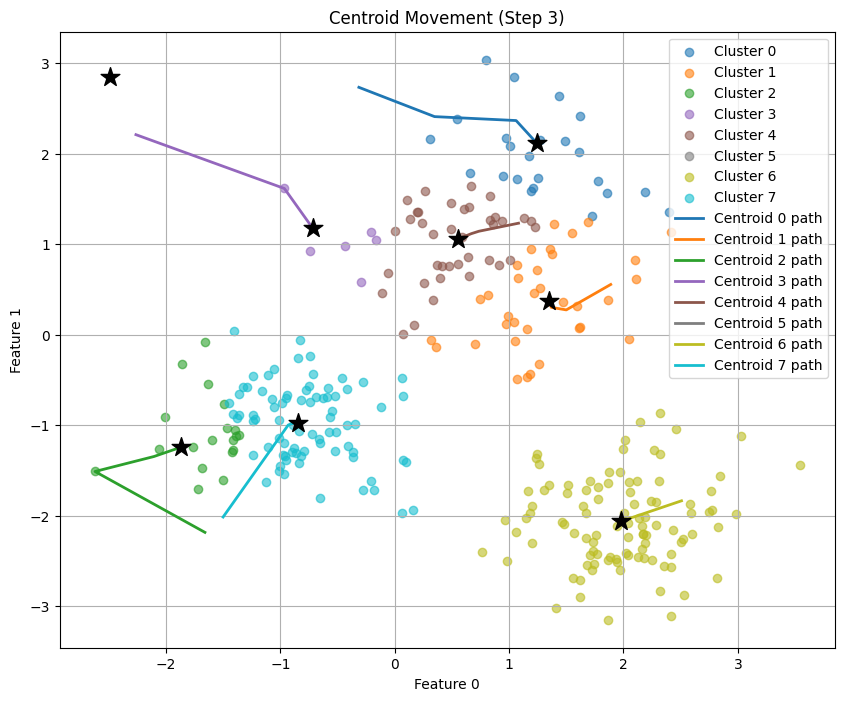

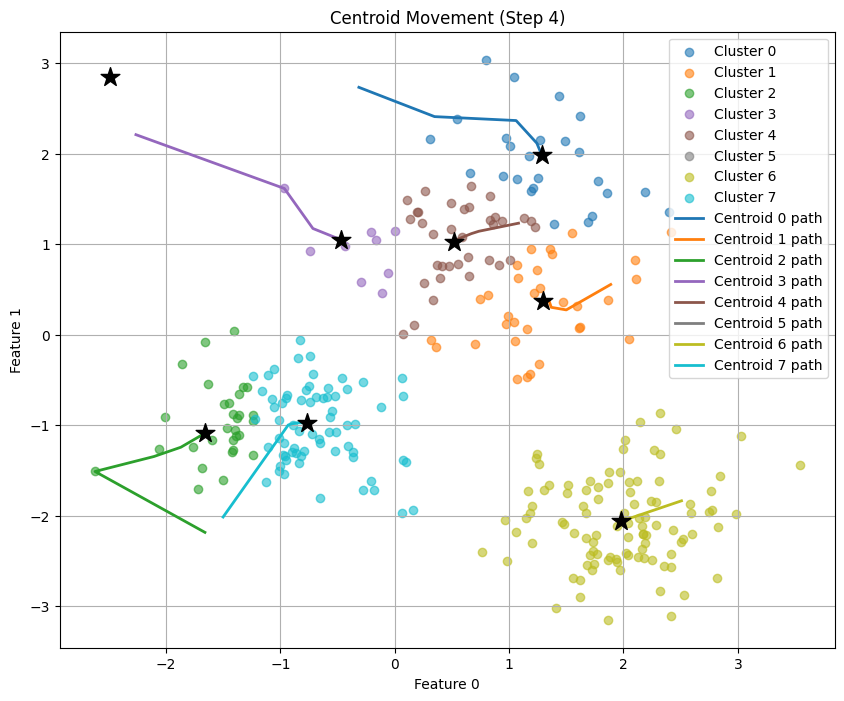

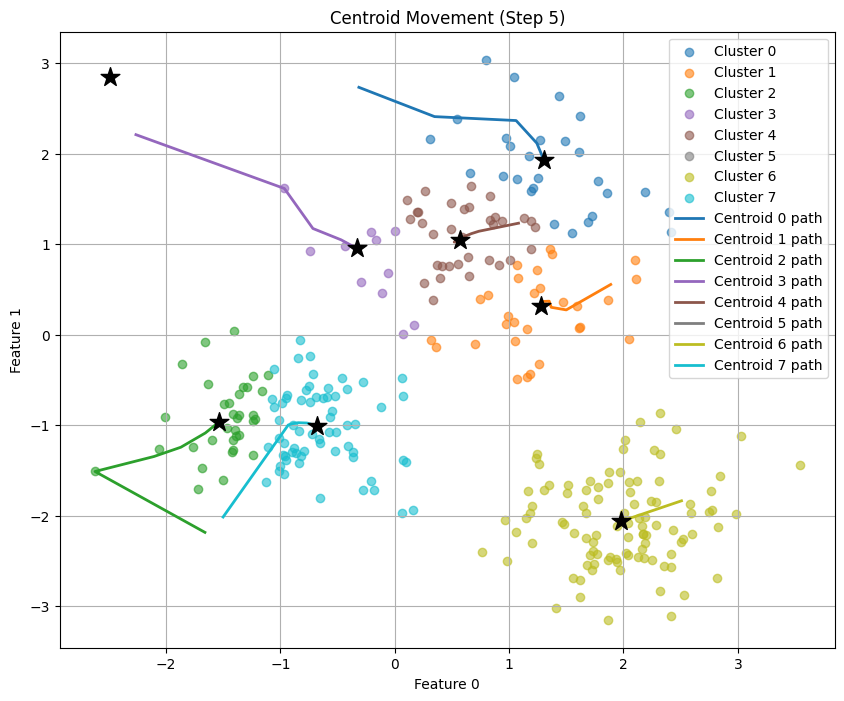

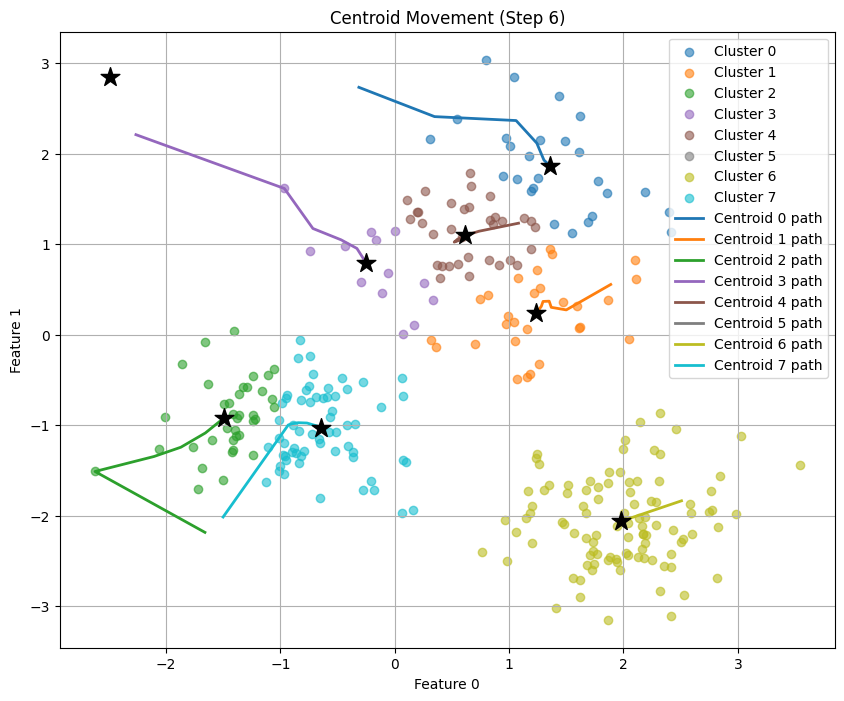

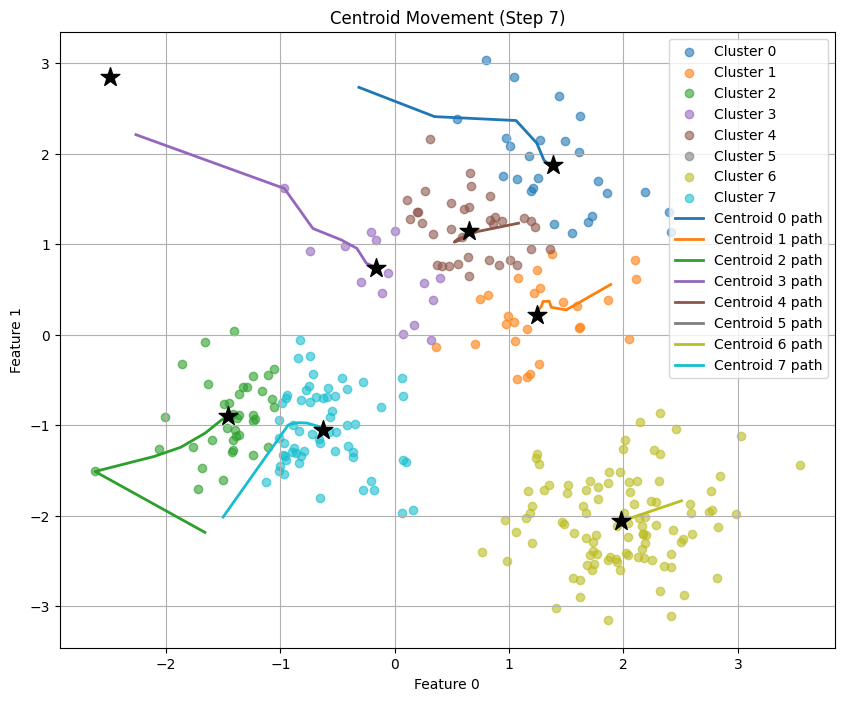

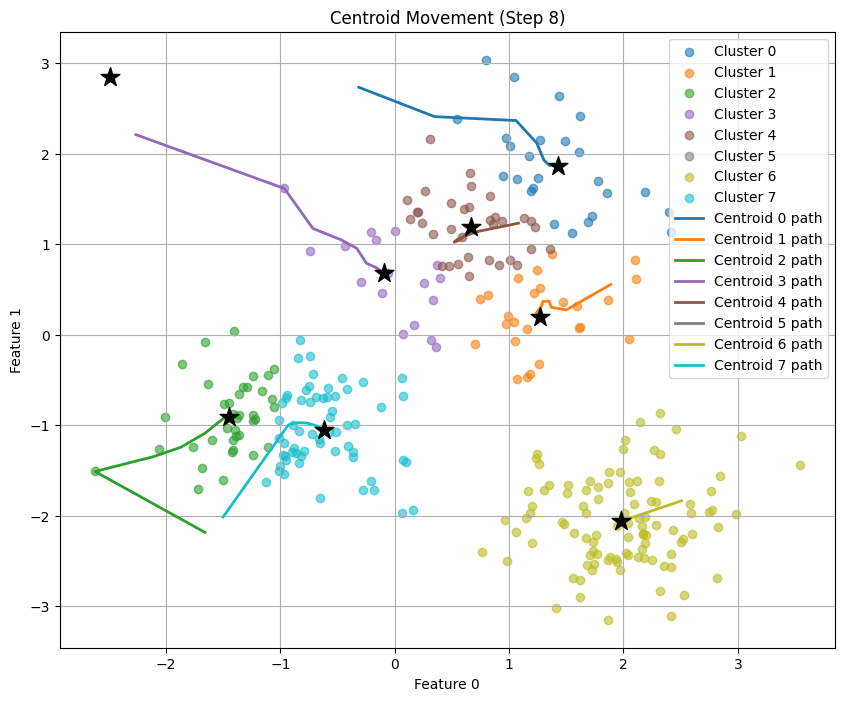

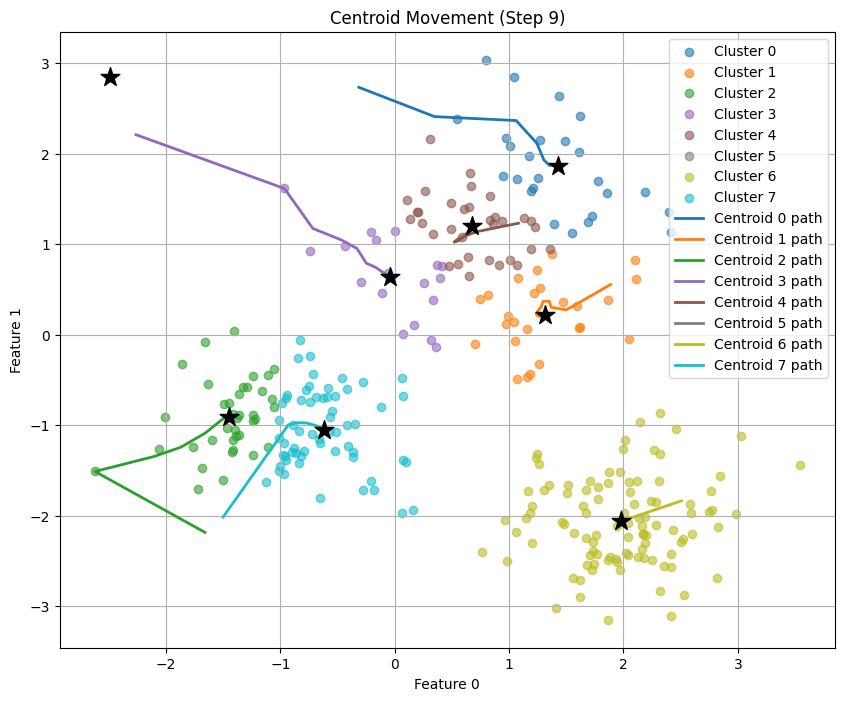

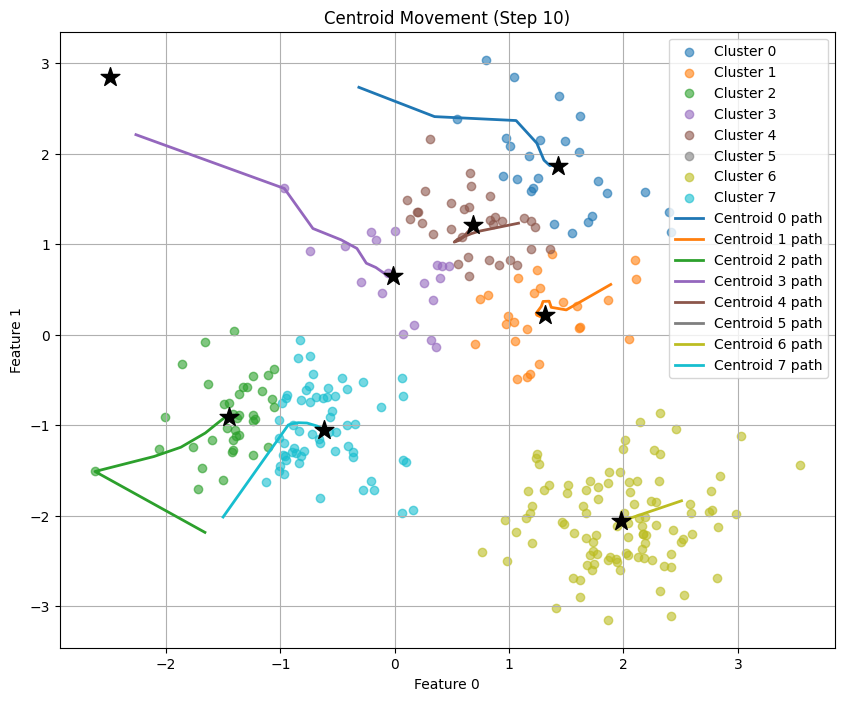

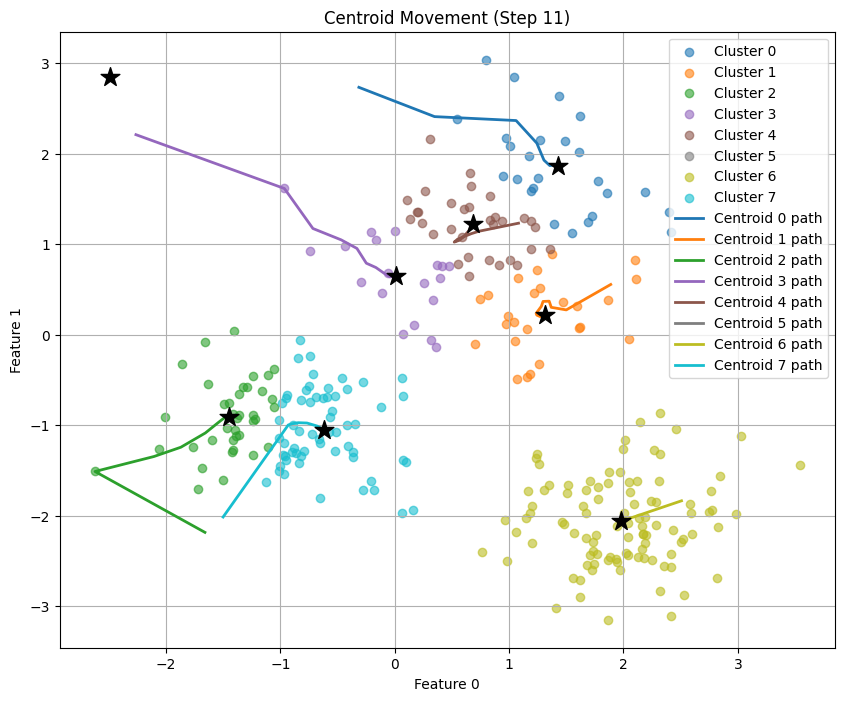

In [17]:
plot_all = True # change
if plot_all:
    # Plot the final result with movement paths
    for i in range(1, len(centroid_history)+1):
        plot_final_result_with_history(data, assignment_history, centroid_history, dims=(0, 1), steps = i)



## Competitive layer

In [18]:
import numpy as np

def competitive_learning(data, k=3, initial_centroids=None, max_iter=300, learning_rate=0.1, distance='euclidean'):
    """
    Competitive learning, i.e., Winner-Takes-All (online) KMeans using NumPy.

    Parameters:
    - data (np.ndarray): dataset of shape (n_samples, n_features)
    - k (int): number of clusters
    - initial_centroids (np.ndarray or str): initial centroids or initialization method
    - max_iter (int): maximum number of updates (not epochs!)
    - learning_rate (float): step size for centroid updates
    - distance (str): distance metric: 'euclidean', 'manhattan', 'cosine'

    Returns:
    - centroids (np.ndarray): final centroid positions
    - centroid_history (list of np.ndarray): centroids at each iteration
    """
    # np.random.seed(42)

    n_samples, n_features = data.shape

    # Step 1: Initialize centroids
    if initial_centroids is None:
        centroids = initialize_centroids(data, k)
    elif isinstance(initial_centroids, np.ndarray):
        centroids = initial_centroids
    elif isinstance(initial_centroids, str):
        centroids = initialize_centroids(data, k, initial_centroids)

    centroid_history = [centroids.copy()]  # Store initial centroids


    for iteration in range(max_iter):
        # Step 2: Select one random sample
        idx = np.random.randint(0, n_samples)
        sample = data[idx:idx+1]  # keep 2D shape

        # Step 3: Compute distances to centroids
        if distance == 'euclidean':
            distances = np.linalg.norm(sample - centroids, axis=1)
        elif distance == 'manhattan':
            distances = np.sum(np.abs(sample - centroids), axis=1)
        elif distance == 'cosine':
            sample_norm = np.linalg.norm(sample, axis=1, keepdims=True)
            centroids_norm = np.linalg.norm(centroids, axis=1, keepdims=True)
            similarity = np.dot(sample, centroids.T) / (sample_norm * centroids_norm.T + 1e-10)
            distances = 1 - similarity
        else:
            raise ValueError("Unsupported distance metric.")

        # Step 4: Find the winning centroid (closest)
        winner_idx = np.argmin(distances)

        # Step 5: Update the winning centroid
        centroids[winner_idx] = (1 - learning_rate) * centroids[winner_idx] + learning_rate * sample

        # Step 6: Record history
        centroid_history.append(centroids.copy())

    # Step 7: Final assignments for all points
    if distance == 'euclidean':
        final_distances = np.linalg.norm(data[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    elif distance == 'manhattan':
        final_distances = np.sum(np.abs(data[:, np.newaxis, :] - centroids[np.newaxis, :, :]), axis=2)
    elif distance == 'cosine':
        data_norm = np.linalg.norm(data, axis=1, keepdims=True)
        centroids_norm = np.linalg.norm(centroids, axis=1, keepdims=True)
        similarity = np.dot(data, centroids.T) / (data_norm * centroids_norm.T + 1e-10)
        final_distances = 1 - similarity

    assignments = np.argmin(final_distances, axis=1)

    return assignments, centroids, centroid_history


### Run the algorithm and visualize the training process:

Centroids:
 [[ 1.42498349  1.86193713]
 [ 1.30991404  0.21237819]
 [-1.45232539 -0.91095705]
 [ 0.0100737   0.65096876]
 [ 0.68832395  1.2266172 ]
 [-2.49383166  2.85383614]
 [ 1.97748131 -2.06313634]
 [-0.61732333 -1.05140353]]


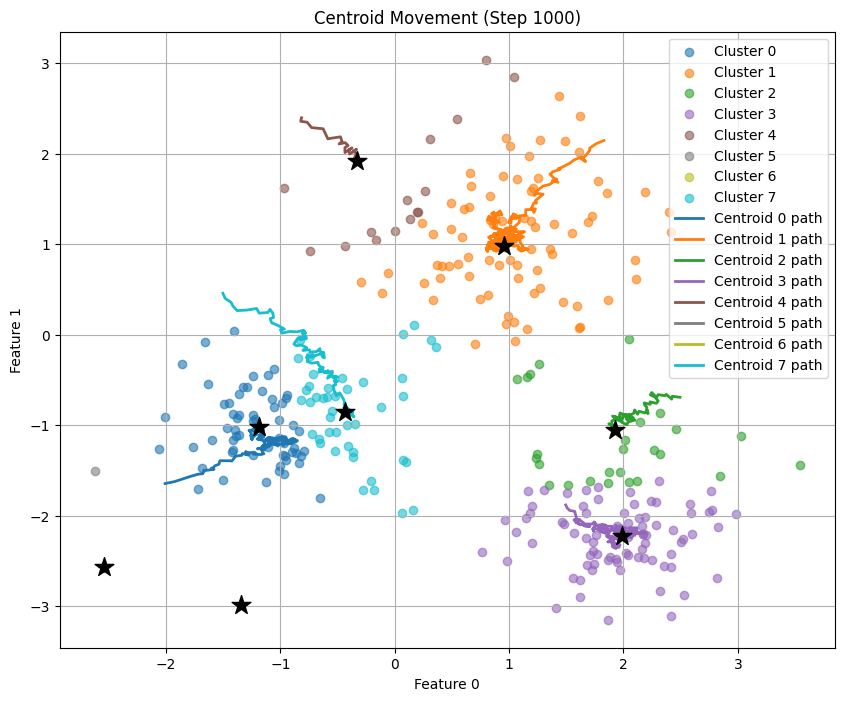

In [20]:
assignments, centroids, centroid_history = competitive_learning(
    data,
    k=k,
    initial_centroids= 'random_range', #'mean', #initial_centroids,  #'random_data',
    max_iter=1000,
    learning_rate=0.05,
    distance='euclidean'
)

# Plot final result
print("Centroids:\n", final_centroids)

# Plot the final result with movement paths
plot_final_result_with_history(data, [assignments for _ in centroid_history] , centroid_history, dims=(0, 1))


## ScikitLearn KMeans

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Centroids:
 [[ 1.42498349  1.86193713]
 [ 1.30252091  0.26039176]
 [-1.52869923 -1.0720207 ]
 [ 0.0100737   0.65096876]
 [ 0.65353843  1.25102092]
 [-0.84864321 -0.54866291]
 [ 1.97748131 -2.06313634]
 [-0.58679299 -1.3122613 ]]


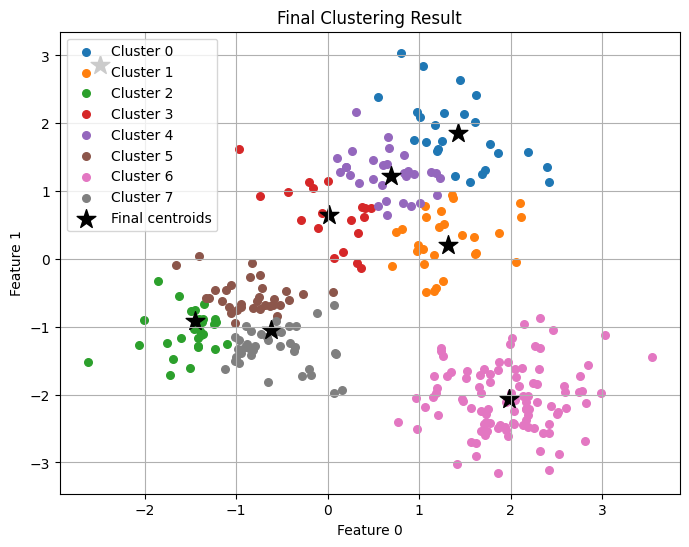

In [21]:
import numpy as np
from sklearn.cluster import KMeans


# Run standard KMeans (single run from our initial centroids)
# Step 2: Apply KMeans clustering
kmeans = KMeans(
    n_clusters=k,             # Number of clusters to form
    init=initial_centroids,   # Initialization method: 'k-means++', 'random', or ndarray of initial centers
    n_init=1,                # Number of times the algorithm will be run with different centroid seeds
    max_iter=300,             # Maximum number of iterations for a single run
    tol=1e-4,                 # Tolerance for convergence (smaller = stricter convergence)
    random_state=42            # Seed for reproducibility
)

kmeans.fit(data)

# Results
assignments = kmeans.labels_          # Cluster assignment for each data point (array shape: [n_samples])
centroids = kmeans.cluster_centers_   # Final cluster centers (array shape: [n_clusters, n_features])
inertia = kmeans.inertia_             # Sum of squared distances of samples to their closest cluster center
n_iter = kmeans.n_iter_               # Number of iterations run

# Plot final result
print("Centroids:\n", centroids)
plot_final_result(data, assignments, final_centroids, dims)



# Evaluate the quality of clustering:

## Plot Silhuette

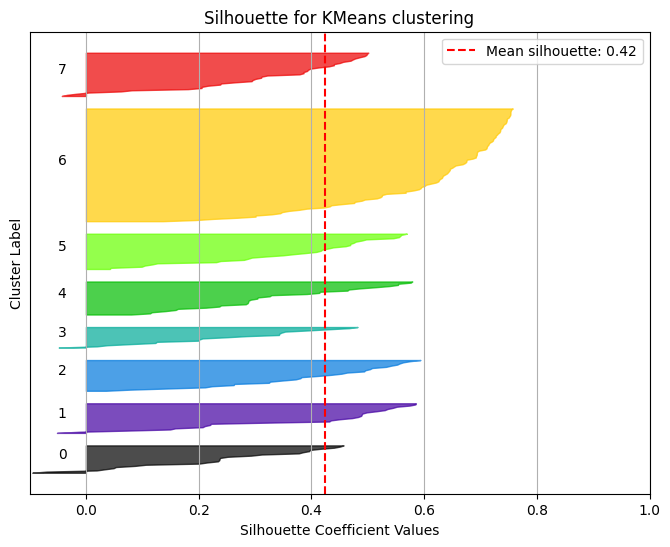

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

def plot_silhouette(data, assignments, title="Silhouette Plot"):
    """
    Plot the silhouette coefficients for a given clustering result.

    Parameters:
    - data (np.ndarray): dataset of shape (n_samples, n_features)
    - assignments (np.ndarray): cluster labels for each sample
    - title (str): plot title
    """
    n_clusters = len(np.unique(assignments))

    if n_clusters < 2:
        raise ValueError("Silhouette plot requires at least 2 clusters.")

    # Compute silhouette scores
    sample_silhouette_values = silhouette_samples(data, assignments)
    mean_silhouette_score = silhouette_score(data, assignments)

    fig, ax = plt.subplots(figsize=(8, 6))

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[assignments == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for spacing between clusters

    ax.set_title(title)
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=mean_silhouette_score, color="red", linestyle="--", label=f"Mean silhouette: {mean_silhouette_score:.2f}")
    ax.legend()
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    plt.grid(True)
    plt.show()

plot_silhouette(data, assignments, title="Silhouette for KMeans clustering")

## Finding the optimal nuber of clusters

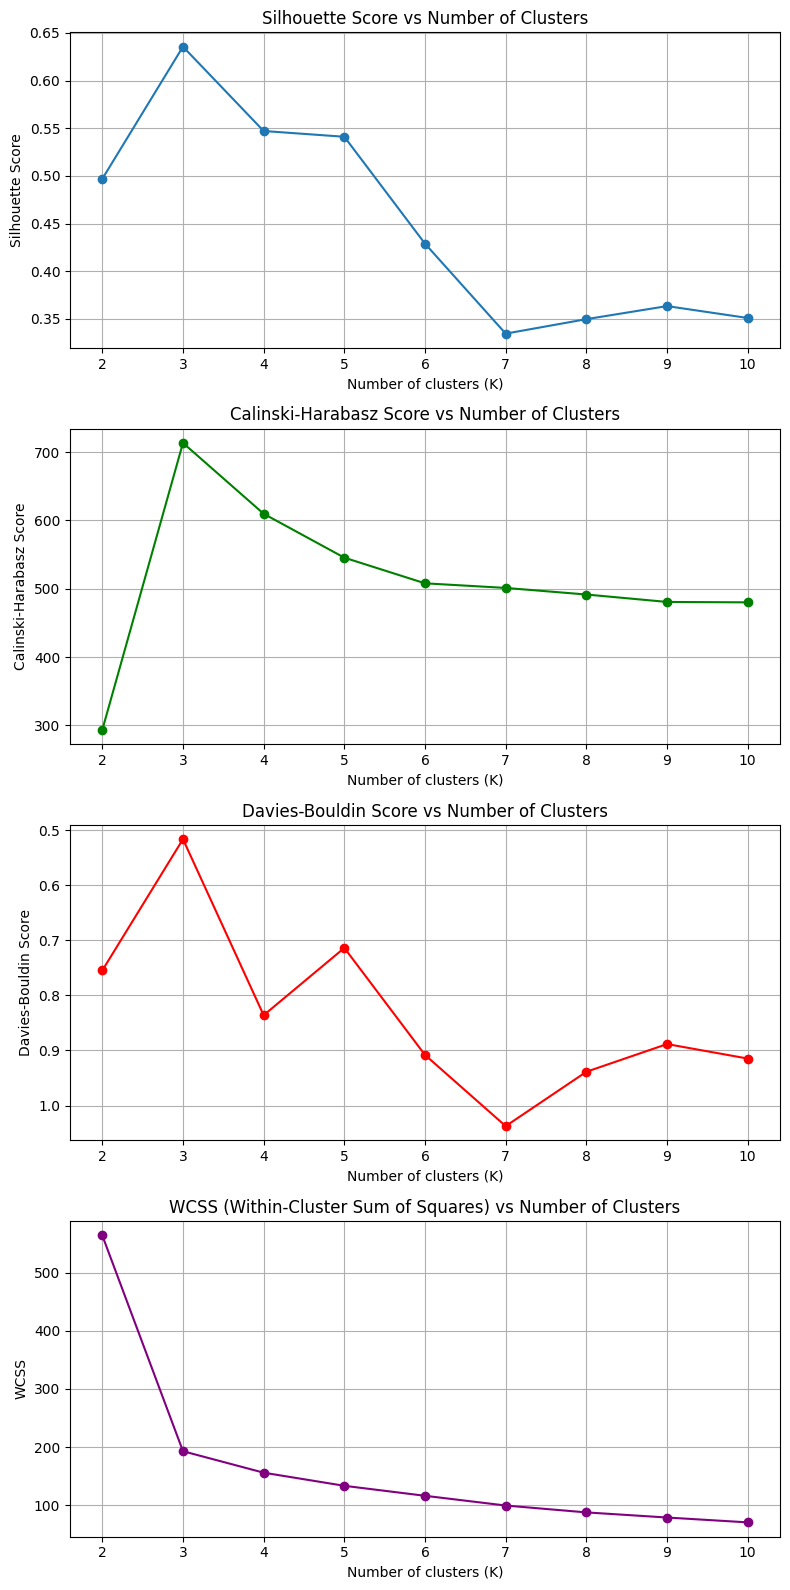

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.datasets import make_blobs

# Step 1: Generate dataset
...

# Step 2: Prepare lists
K_range = range(2, 11)  # Try K from 2 to 10
silhouette_scores = []
calinski_scores = []
davies_scores = []
wcss_scores = []

# Step 3: Compute metrics for each K
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(data)

    silhouette_scores.append(silhouette_score(data, labels))
    calinski_scores.append(calinski_harabasz_score(data, labels))
    davies_scores.append(davies_bouldin_score(data, labels))
    wcss_scores.append(kmeans.inertia_)  # <- NEW

# Step 4: Plot the results
fig, axs = plt.subplots(4, 1, figsize=(8, 16))  # <- 4 plots instead of 3

# Silhouette
axs[0].plot(K_range, silhouette_scores, marker='o')
axs[0].set_title('Silhouette Score vs Number of Clusters')
axs[0].set_xlabel('Number of clusters (K)')
axs[0].set_ylabel('Silhouette Score')
axs[0].grid(True)

# Calinski-Harabasz
axs[1].plot(K_range, calinski_scores, marker='o', color='green')
axs[1].set_title('Calinski-Harabasz Score vs Number of Clusters')
axs[1].set_xlabel('Number of clusters (K)')
axs[1].set_ylabel('Calinski-Harabasz Score')
axs[1].grid(True)

# Davies-Bouldin
axs[2].plot(K_range, davies_scores, marker='o', color='red')
axs[2].set_title('Davies-Bouldin Score vs Number of Clusters')
axs[2].set_xlabel('Number of clusters (K)')
axs[2].set_ylabel('Davies-Bouldin Score')
axs[2].invert_yaxis()  # For Davies-Bouldin lower is better
axs[2].grid(True)

# WCSS (Elbow Method)
axs[3].plot(K_range, wcss_scores, marker='o', color='purple')
axs[3].set_title('WCSS (Within-Cluster Sum of Squares) vs Number of Clusters')
axs[3].set_xlabel('Number of clusters (K)')
axs[3].set_ylabel('WCSS')
axs[3].grid(True)

plt.tight_layout()
plt.show()


### Silhouette for the winner clustering

Best K according to Silhouette: 3
Best K according to Calinski-Harabasz: 3
Best K according to Davies-Bouldin: 3
Best K according to Elbow (WCSS): 3


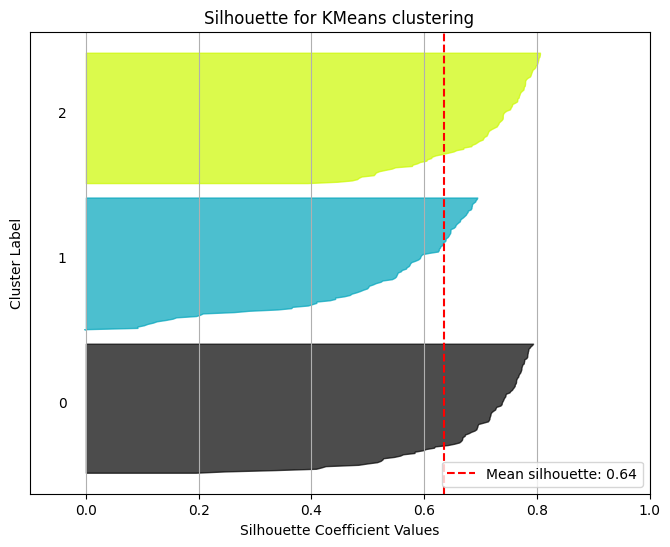

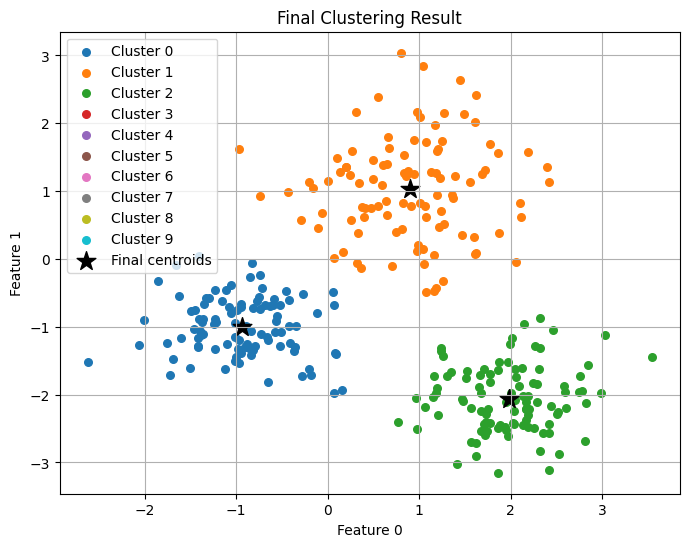

In [32]:
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
optimal_k_calinski = K_range[np.argmax(calinski_scores)]
optimal_k_davies = K_range[np.argmin(davies_scores)]
wcss_diffs = np.diff(wcss_scores)
optimal_k_wcss = K_range[np.argmax(-wcss_diffs)+1]   # point of greatest decline

print(f"Best K according to Silhouette: {optimal_k_silhouette}")
print(f"Best K according to Calinski-Harabasz: {optimal_k_calinski}")
print(f"Best K according to Davies-Bouldin: {optimal_k_davies}")
print(f"Best K according to Elbow (WCSS): {optimal_k_wcss}")

# silouhette plot for the winner:
kmeans = KMeans(n_clusters=optimal_k_silhouette, n_init=10, random_state=42)
labels = kmeans.fit_predict(data)
plot_silhouette(data, labels, title="Silhouette for KMeans clustering")


# plt the final clusters:
final_centroids = kmeans.cluster_centers_
plot_final_result(data, labels, final_centroids, dims)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)  # inertia_ je WCSS v sklearn implementaci

# Vykreslení grafu
plt.figure(figsize=(8,5))
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Finding Optimal k')
plt.grid(True)
plt.show()